In [75]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [77]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [78]:
train_x = train_x.cuda()
train_y = train_y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()

In [79]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# find optimal model hyperparameters
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.941   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.909   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.876   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.838   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.796   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.749   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.698   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.647   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.598   lengthscale: 0.372   noise: 0.369
Iter 10/50 - Loss: 0.553   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.513   lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.477   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.442   lengthscale: 0.273   noise: 0.259
Iter 14/50 - Loss: 0.408   lengthscale: 0.257   noise: 0.237
Iter 15/50 - Loss: 0.375   lengthscale: 0.243   noise: 0.216
Iter 16/50 - Loss: 0.343   lengthscale: 0.233   noise: 0.196
Iter 17/50 - Loss: 0.311   length

In [18]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Test points are regularly spaced along [0,1]
    test_x = torch.linspace(0, 1, 51)
    # Make predictions
    observed_pred = likelihood(model(test_x))

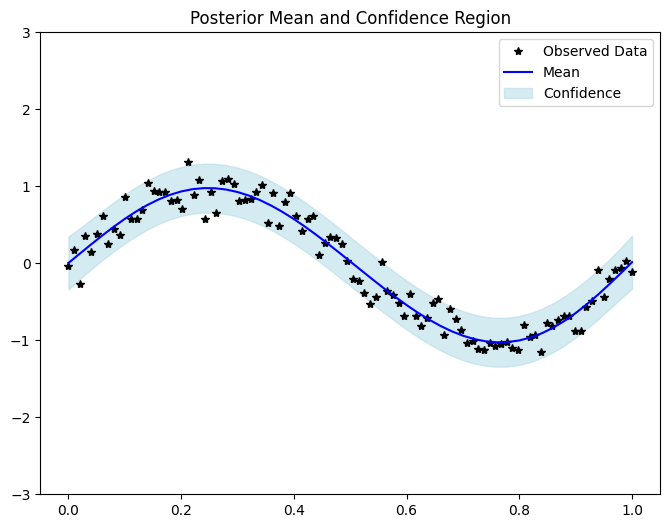

In [19]:
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5
                    , color='lightblue')
    ax.set_ylim([-3, 3])
    ax.set_title('Posterior Mean and Confidence Region')
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [20]:
## Basic usage tutorial


import math
import torch
import gpytorch
from matplotlib import pyplot as plt

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [21]:
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [22]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')



Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.raw_constant                   value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


In [28]:
raw_outputscale = model.covar_module.raw_outputscale
print('raw_outputscale, ', raw_outputscale)

# Three ways of accessing the raw outputscale constraint
print('\nraw_outputscale_constraint1', model.covar_module.raw_outputscale_constraint)

printmd('\n\n**Printing all model constraints...**\n')
for constraint_name, constraint in model.named_constraints():
    print(f'Constraint name: {constraint_name:55} constraint = {constraint}')

printmd('\n**Getting raw outputscale constraint from model.covar_module...**')
print(model.covar_module.constraint_for_parameter_name("raw_outputscale"))

raw_outputscale,  Parameter containing:
tensor(0., requires_grad=True)

raw_outputscale_constraint1 Positive()




**Printing all model constraints...**


Constraint name: likelihood.noise_covar.raw_noise_constraint             constraint = GreaterThan(1.000E-04)
Constraint name: covar_module.raw_outputscale_constraint                 constraint = Positive()
Constraint name: covar_module.base_kernel.raw_lengthscale_constraint     constraint = Positive()



**Getting raw outputscale constraint from model.covar_module...**

Positive()


In [29]:
raw_outputscale = model.covar_module.raw_outputscale
constraint = model.covar_module.raw_outputscale_constraint


print('Transformed outputscale', constraint.transform(raw_outputscale))
print(constraint.inverse_transform(constraint.transform(raw_outputscale)))
print(torch.equal(constraint.inverse_transform(constraint.transform(raw_outputscale)), raw_outputscale))

print('Transform a bunch of negative tensors: ', constraint.transform(torch.tensor([-1., -2., -3.])))

Transformed outputscale tensor(0.6931, grad_fn=<SoftplusBackward0>)
tensor(0., grad_fn=<AddBackward0>)
True
Transform a bunch of negative tensors:  tensor([0.3133, 0.1269, 0.0486])


In [30]:
# Recreate model to reset outputscale
model = ExactGPModel(train_x, train_y, likelihood)

# Convenient way of getting true outputscale
print(f'Actual outputscale: {model.covar_module.outputscale}')

# Convenient way of setting true outputscale
model.covar_module.outputscale = 2.
print(f'Actual outputscale after setting: {model.covar_module.outputscale}')



Actual outputscale: 0.6931471824645996
Actual outputscale after setting: 2.0


In [31]:
print(f'Actual noise value: {likelihood.noise}')
print(f'Noise constraint: {likelihood.noise_covar.raw_noise_constraint}')

Actual noise value: tensor([0.6932], grad_fn=<AddBackward0>)
Noise constraint: GreaterThan(1.000E-04)


In [34]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-3))
print(f'Noise constraint: {likelihood.noise_covar.raw_noise_constraint}')

## Changing the constraint after the module has been created
likelihood.noise_covar.register_constraint("raw_noise", gpytorch.constraints.Positive())
print(f'Noise constraint: {likelihood.noise_covar.raw_noise_constraint}')

Noise constraint: GreaterThan(1.000E-03)
Noise constraint: Positive()


In [36]:
# Registers a prior on the sqrt of the noise parameter
# (e.g., a prior for the noise standard deviation instead of variance)
likelihood.noise_covar.register_prior(
    "noise_std_prior",
    gpytorch.priors.NormalPrior(0, 1),
    lambda module: module.noise.sqrt()
)

In [37]:
# Create a GaussianLikelihood with a normal prior for the noise
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-3),
    noise_prior=gpytorch.priors.NormalPrior(0, 1)
)

In [ ]:
class FancyGPWithPriors(gpytorch.models.ExactGP):
    def __init__(self,train_x,train_y, likelihood):
        super(FancyGPWithPriors, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        lengthscale_prior = gpytorch.priors.GammaPrior(3.0, 6.0)
        outputscale_prior = gpytorch.priors.GammaPrior(2.0, 0.15)

        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
            outputscale_prior=outputscale_prior
        )

    
        self.covar_module.base_kernel.lengthscale = lengthscale_prior.mean
        self.covar_module.outputscale = outputscale_prior.mean

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-2),
)

model = FancyGPWithPriors(train_x, train_y, likelihood)


In [39]:
hypers = {
    'likelihood.noise_covar.noise': torch.tensor(1.),
    'covar_module.base_kernel.lengthscale': torch.tensor(0.5),
    'covar_module.outputscale': torch.tensor(2.),
}

model.initialize(**hypers)
print(
    model.likelihood.noise_covar.noise.item(),
    model.covar_module.base_kernel.lengthscale.item(),
    model.covar_module.outputscale.item()
)



1.0 0.5 2.0


In [46]:
#GP classification
def gen_data(num_data, seed = 1):
    torch.random.manual_seed(seed)

    x = torch.randn(num_data,1)
    y = torch.randn(num_data,1)

    u = torch.rand(1)
    data_fn = lambda x, y: 1 * torch.sin(0.15 * u * 3.1415 * (x + y)) + 1
    latent_fn = data_fn(x, y)
    z = torch.round(latent_fn).long().squeeze()
    return torch.cat((x,y),dim=1), z, data_fn

In [47]:
train_x, train_y, genfn = gen_data(500)

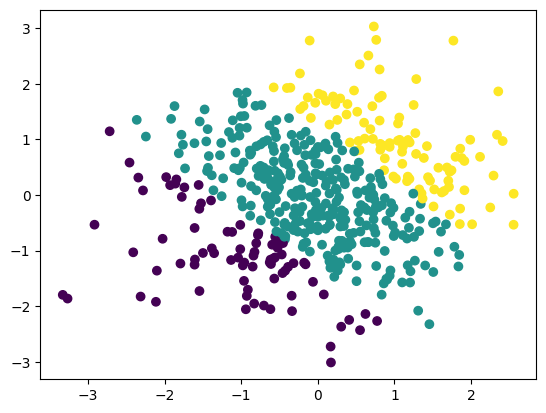

In [48]:
plt.scatter(train_x[:,0].numpy(), train_x[:,1].numpy(), c = train_y)

In [52]:
test_d1 = np.linspace(-3, 3, 20)
test_d2 = np.linspace(-3, 3, 20)

In [54]:
test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

In [60]:
test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)
test_labels = torch.round(genfn(test_x_mat, test_y_mat))
test_labels.view(-1).shape

torch.Size([400])

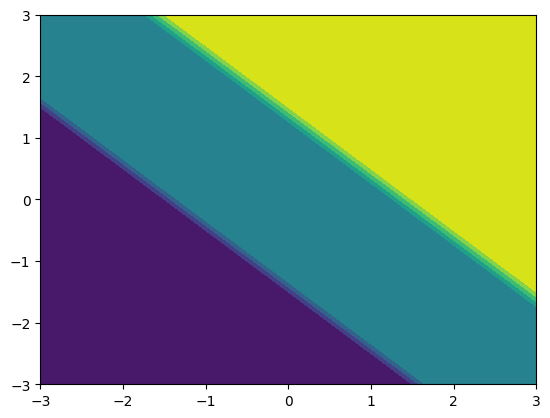

In [61]:
plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())

In [62]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

In [64]:
# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

In [65]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

In [66]:
# Find optimal model hyperparameters
model.train()
likelihood.train()


DirichletClassificationLikelihood(
  (noise_covar): FixedGaussianNoise()
  (second_noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [67]:
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters


In [68]:
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


In [69]:
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/50 - Loss: 6.358   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 5.856   lengthscale: 0.947   noise: 0.475
Iter 11/50 - Loss: 5.679   lengthscale: 1.102   noise: 0.322
Iter 16/50 - Loss: 5.558   lengthscale: 1.086   noise: 0.222
Iter 21/50 - Loss: 5.414   lengthscale: 0.954   noise: 0.158
Iter 26/50 - Loss: 5.331   lengthscale: 0.811   noise: 0.115
Iter 31/50 - Loss: 5.259   lengthscale: 0.714   noise: 0.085
Iter 36/50 - Loss: 5.212   lengthscale: 0.665   noise: 0.065
Iter 41/50 - Loss: 5.189   lengthscale: 0.646   noise: 0.050
Iter 46/50 - Loss: 5.167   lengthscale: 0.631   noise: 0.040


In [70]:
model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)

    pred_means = test_dist.loc

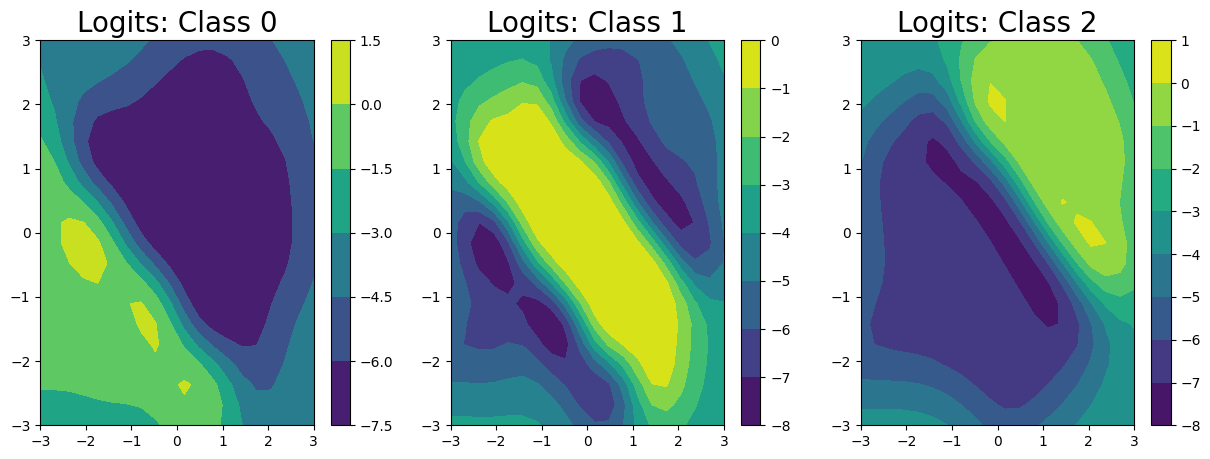

In [71]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), pred_means[i].numpy().reshape((20,20))
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)

In [72]:
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

c:\Users\anton\source\repos\nl-pe\.venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\anton\source\repos\nl-pe\.venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


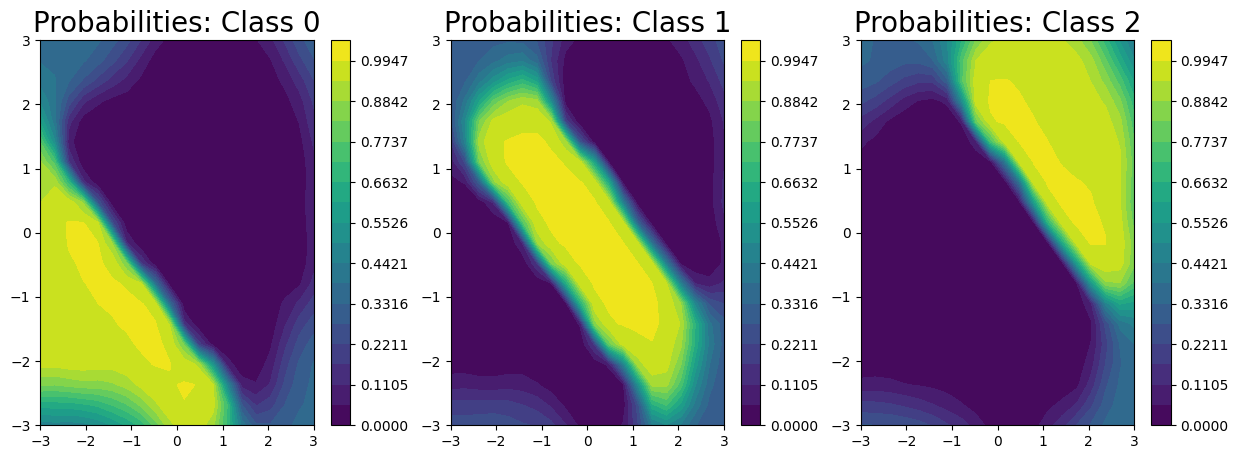

In [73]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

levels = np.linspace(0, 1.05, 20)
for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), probabilities[i].numpy().reshape((20,20)), levels=levels
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

Text(0.5, 1.0, 'Estimated Response')

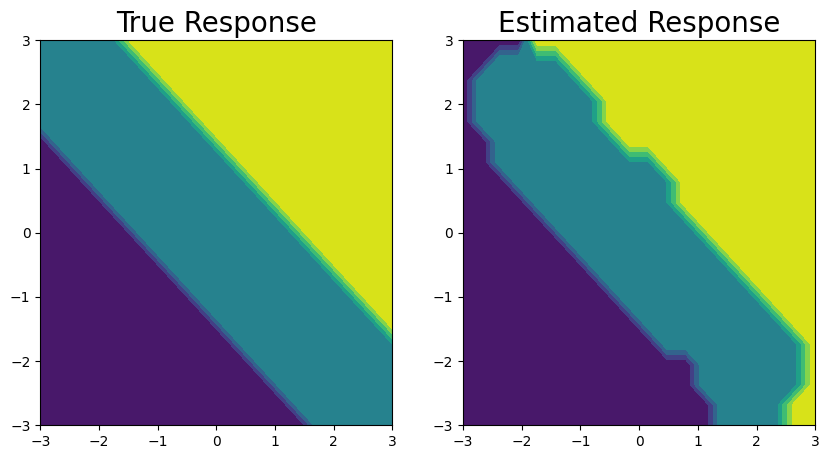

In [74]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Response', fontsize=20)

ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_means.max(0)[1].reshape((20,20)))
ax[1].set_title('Estimated Response', fontsize=20)